<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/2_2_RNN_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load Data

In [6]:
file = "/content/gdrive/MyDrive/neural_data/TimeSeriesData/Alcohol_Sales.csv"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
df = pd.read_csv(file,index_col=0,parse_dates=True)
len(df)

325

In [9]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [8]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

## Plotting time series data

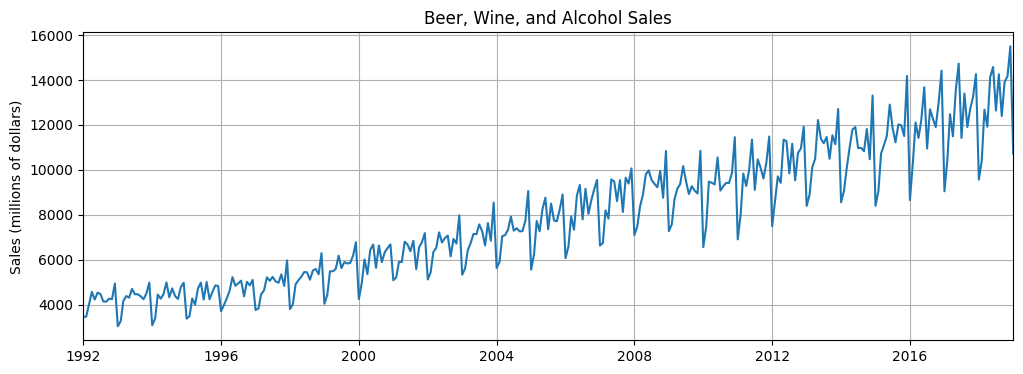

In [10]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data

In [11]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [12]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [14]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [16]:
train_norm.min(), train_norm.max(), train_norm.mean()

(-1.0, 1.0, -0.2041940178388313)

In [17]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM

In [18]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [19]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Define the model

In [20]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [21]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [23]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):

    # extract the sequence & label from the training data
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310197
Epoch:  2 Loss: 0.37531978
Epoch:  3 Loss: 0.39027214
Epoch:  4 Loss: 0.34934697
Epoch:  5 Loss: 0.33085644
Epoch:  6 Loss: 0.33229974
Epoch:  7 Loss: 0.32670349
Epoch:  8 Loss: 0.32074124
Epoch:  9 Loss: 0.30653533
Epoch: 10 Loss: 0.29518029
Epoch: 11 Loss: 0.26934299
Epoch: 12 Loss: 0.25998408
Epoch: 13 Loss: 0.24665910
Epoch: 14 Loss: 0.22404005
Epoch: 15 Loss: 0.18602598
Epoch: 16 Loss: 0.18560922
Epoch: 17 Loss: 0.17209204
Epoch: 18 Loss: 0.25159547
Epoch: 19 Loss: 0.22557092
Epoch: 20 Loss: 0.17442545
Epoch: 21 Loss: 0.20229681
Epoch: 22 Loss: 0.20836267
Epoch: 23 Loss: 0.16665521
Epoch: 24 Loss: 0.17565002
Epoch: 25 Loss: 0.12000708
Epoch: 26 Loss: 0.08967862
Epoch: 27 Loss: 0.03701421
Epoch: 28 Loss: 0.02373669
Epoch: 29 Loss: 0.00229948
Epoch: 30 Loss: 0.03979736
Epoch: 31 Loss: 0.06725731
Epoch: 32 Loss: 0.00004387
Epoch: 33 Loss: 0.01273915
Epoch: 34 Loss: 0.03655604
Epoch: 35 Loss: 0.04811488
Epoch: 36 Loss: 0.02647598
Epoch: 37 Loss: 0.01207672
E

## Run predictions and compare to known test test

In [24]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [25]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.07850729674100876,
 0.636172890663147,
 0.47952455282211304,
 0.797539234161377,
 1.037564754486084,
 0.40570196509361267,
 0.684086799621582,
 0.5318096876144409,
 0.623979926109314,
 0.8358430862426758,
 0.9882886409759521,
 0.10908076912164688]

## Invert the normalization

In [26]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[ 9339.72843229],
       [12601.79332393],
       [11685.47887173],
       [13545.70575023],
       [14949.73503137],
       [11253.65364482],
       [12882.06573439],
       [11991.3207677 ],
       [12530.47057778],
       [13769.76413298],
       [14661.49440539],
       [ 9518.56795898]])

In [27]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

## Plot the results

In [28]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

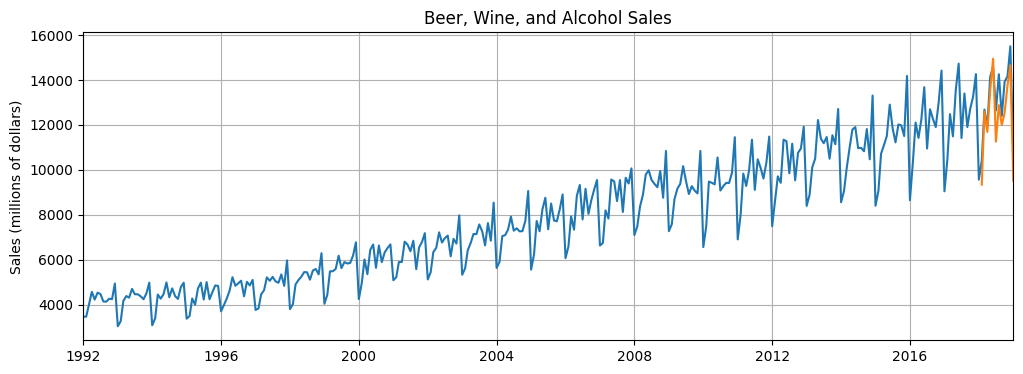

In [29]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

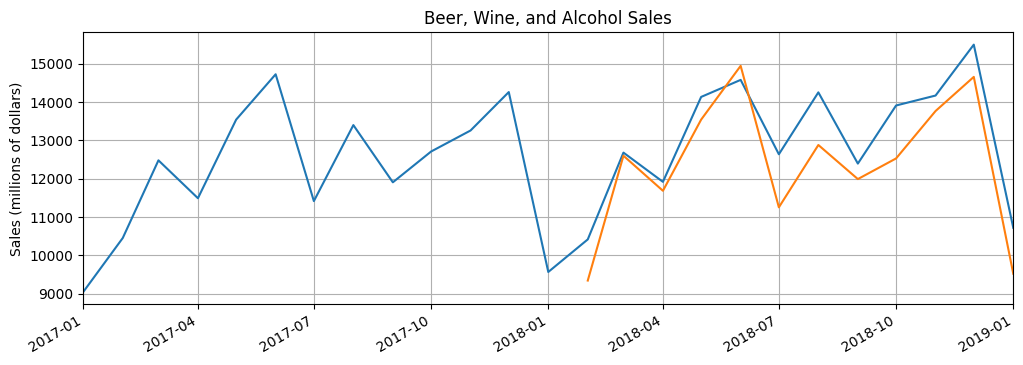

In [30]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## Forest into an unknown future

In [31]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    # train on the full set of sequences
    for seq, y_train in all_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01267121
Epoch:  2 Loss: 0.01976519
Epoch:  3 Loss: 0.02548520
Epoch:  4 Loss: 0.02033432
Epoch:  5 Loss: 0.01827073
Epoch:  6 Loss: 0.00906334
Epoch:  7 Loss: 0.01388814
Epoch:  8 Loss: 0.01321159
Epoch:  9 Loss: 0.01248318
Epoch: 10 Loss: 0.01335394
Epoch: 11 Loss: 0.01502570
Epoch: 12 Loss: 0.01420263
Epoch: 13 Loss: 0.00694072
Epoch: 14 Loss: 0.00477246
Epoch: 15 Loss: 0.00848586
Epoch: 16 Loss: 0.00774913
Epoch: 17 Loss: 0.00645402
Epoch: 18 Loss: 0.00590211
Epoch: 19 Loss: 0.00499587
Epoch: 20 Loss: 0.00265786
Epoch: 21 Loss: 0.00189189
Epoch: 22 Loss: 0.00187656
Epoch: 23 Loss: 0.00646459
Epoch: 24 Loss: 0.00550164
Epoch: 25 Loss: 0.00393064
Epoch: 26 Loss: 0.00282347
Epoch: 27 Loss: 0.00237323
Epoch: 28 Loss: 0.00245375
Epoch: 29 Loss: 0.00512760
Epoch: 30 Loss: 0.01216990
Epoch: 31 Loss: 0.00265577
Epoch: 32 Loss: 0.00003214
Epoch: 33 Loss: 0.00050937
Epoch: 34 Loss: 0.00029517
Epoch: 35 Loss: 0.00811921
Epoch: 36 Loss: 0.00080631
Epoch: 37 Loss: 0.00000266
E

## Plot future values, plot the result

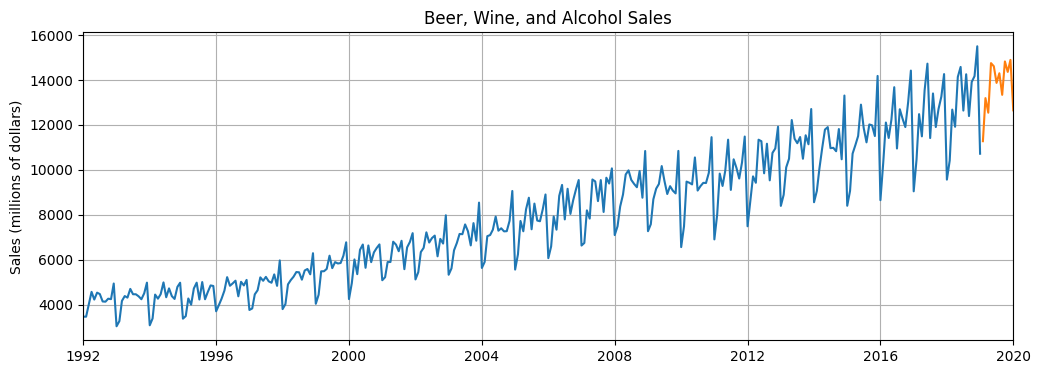

In [32]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

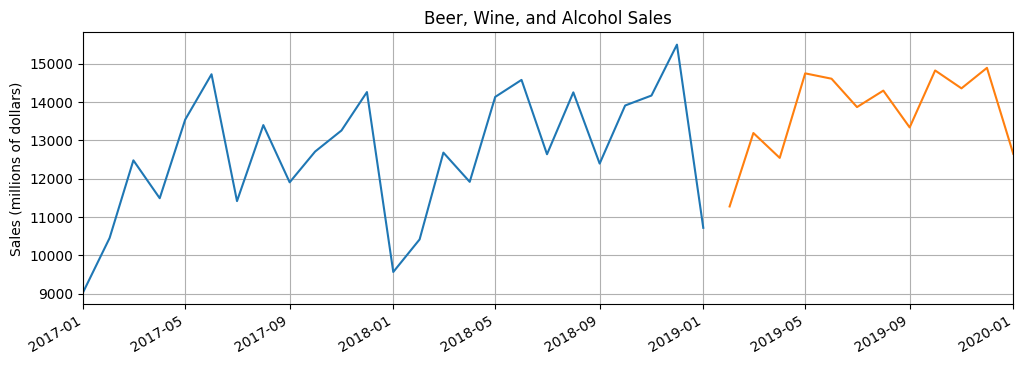

In [33]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

## Function for time series and output tensor of (seq, label) tuples

In [35]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv(file,index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [36]:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [37]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

301

In [38]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [39]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

